# Cross-resonance gate between a transmon and a fluxonium: driving fluxonium

In this notebook we study the cross-resonance two-qubit gate between a transmon and a fluxonium. 

In [1]:
import numpy as np
from collections import defaultdict
import scipy.integrate
import time
import qutip as qtp
from scipy.optimize import minimize
import pysqkit
from pysqkit import QubitSystem
from pysqkit.drives.pulse_shapes import gaussian_top
from pysqkit.util.metrics import average_process_fidelity, \
    average_gate_fidelity
from pysqkit.util.phys import temperature_to_thermalenergy
import pysqkit.util.transformations as trf
from pysqkit.util.linalg import get_mat_elem
from pysqkit.util.hsbasis import weyl_by_index
import cmath
import multiprocessing
from functools import partial
import json
from typing import List, Dict, Callable
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
import util_cr as util

/Users/boris/.pyenv/versions/3.8.2/lib/python3.8/site-packages/qutip/__init__.py:59: UserWarning: Old version of Cython detected: needed 0.29.20, got 0.29.16.
  warnings.warn(


In [2]:
def extract_params(
    transmon: pysqkit.Qubit, 
    fluxonium: pysqkit.Qubit,
    coup_strength: float,
    eps_drive: float,
) -> Dict[str, float]:
    """
    Description
    --------------------------------------------------------------
    Returns the transition frequencies that lead to frequency collisions.
    """
    coupled_levels = dict(
        F = [("0", "1"), ("0", "2"), ("0", "3"), ("0", "4"), ("0", "5"), ("1", "2"), ("1", "3"), ("1", "4"), ("1", "5")],
        T = [("0", "1"), ("1", "2"), ("0", "2")]
    )
    
    coupled_sys = transmon.couple_to(
        fluxonium, 
        coupling=pysqkit.couplers.capacitive_coupling, 
        strength=coup_strength,
    )
    
    comp_states = {}
    for label in ["00", "01", "10", "11"]:
        state_tmp = coupled_sys.state(label)[1]
        
        loc = np.argmax(np.abs(state_tmp))
        phase = cmath.phase(state_tmp[loc])
        state_tmp = np.exp(-1j*phase)*state_tmp
        comp_states[label] = state_tmp

    results = dict(
    )
    for qubit in (transmon, fluxonium):
        label = qubit.label
        
        for level_i, level_j in coupled_levels[label]:
            freq_i = qubit.state(level_i)[0]
            freq_j = qubit.state(level_j)[0]
            trans_freq = freq_j - freq_i
            results[f"{label}_freq_{level_i}_{level_j}"] = trans_freq

    return results

In [3]:
def mu_yz_flx(comp_states, op) -> float:
    yz0 = get_mat_elem(op, comp_states['00'], comp_states['10'])
    yz1 = get_mat_elem(op, comp_states['01'], comp_states['11'] )
    return (np.imag(yz0 - yz1))/2

def mu_yi_flx(comp_states, op) -> float:
    yz0 = get_mat_elem(op, comp_states['00'], comp_states['10'] )
    yz1 = get_mat_elem(op, comp_states['01'], comp_states['11'] )
    return (np.imag(yz0 + yz1))/2

In [4]:
def func_to_minimize(
    pulse_time: list,
    t_rise: float,
    eps: float
) -> float:
    step = 1e-3
    n_points = int(pulse_time[0]/step)
    times = np.linspace(0, pulse_time[0], n_points)
    pulse = gaussian_top(times, t_rise, pulse_time[0])
    integral = scipy.integrate.simpson(2*np.pi*eps*pulse, times)
    return np.abs(integral - np.pi/2) 

In [5]:
def cry(theta):
    ide = np.identity(4)
    yz = np.kron(np.array([[0, -1j], [1j, 0]]), np.array([[1, 0], [0, -1]]))
    return np.cos(theta/2)*ide - 1j*np.sin(theta/2)*yz

def crx(theta):
    ide = np.identity(4)
    zx = np.kron(np.array([[0, 1], [1, 0]]), np.array([[1, 0], [0, -1]]))
    return np.cos(theta/2)*ide - 1j*np.sin(theta/2)*zx

def ry(theta):
    rot_y = np.cos(theta/2)*np.identity(2) - \
        1j*np.sin(theta/2)*np.array([[0, -1j], [1j, 0]])
    return np.kron(rot_y, np.identity(2))

In [6]:
def get_comp_states(coupled_sys):
    state_label = ["00", "01", "10", "11"]
    
    comp_states = {}
    for label in state_label:
        state_tmp = coupled_sys.state(label)[1]
        loc = np.argmax(np.abs(state_tmp))
        phase = cmath.phase(state_tmp[loc])
        state_tmp = np.exp(-1j*phase)*state_tmp
        comp_states[label] = state_tmp

    return comp_states

In [7]:
def get_leakage(
    gate_time: float, 
    system: QubitSystem,
    t_rise: float,
    eps_drive:float,
    freq_drive: float,
    comp_states_list: List 
):
    pts_per_drive_period = 5.0

    nb_points = int(gate_time*freq_drive*pts_per_drive_period)
    tlist = np.linspace(0, gate_time, nb_points)

    system['F'].drives['cr_drive_f'].set_params(phase=0, 
                                                time=tlist, 
                                                rise_time=t_rise, 
                                                pulse_time=gate_time, 
                                                amp=eps_drive, 
                                                freq=freq_drive)
    
    simu_opt = qtp.solver.Options()
    simu_opt.atol = 1e-12
    simu_opt.rtol = 1e-10

    env_syst = pysqkit.tomography.TomoEnv(system=system, 
                                          time=2*np.pi*tlist, 
                                          options=simu_opt, 
                                          with_noise=False)
    env_syst_noise = pysqkit.tomography.TomoEnv(system=system, 
                                          time=2*np.pi*tlist, 
                                          options=simu_opt, 
                                          with_noise=True)
    
    #n_process = 1
    avg_leakage = env_syst.leakage(comp_states_list)
    avg_leakage_noise = env_syst_noise.leakage(comp_states_list)
    
    result = {"gate_time": gate_time,
             "avg_leakage": avg_leakage, 
             "avg_leakage_noise": avg_leakage_noise}
    
    return result    

# Introducing the qubits and the coupled system

In [8]:
with open('../flx_transm_params.txt') as param_file:
    parameters_set = json.load(param_file)

In [9]:
temperature = 0.020 #0.020 # K
thermal_energy = temperature_to_thermalenergy(temperature) # kb T/h in GHz
d_comp = 4

p_set = "2"

#Transmon
levels_t = 3
transm = pysqkit.qubits.SimpleTransmon(
    label='T', 
    max_freq=parameters_set[p_set]["max_freq_t"] + 0.84, 
    anharm=parameters_set[p_set]["anharm_t"],
    diel_loss_tan=parameters_set[p_set]["diel_loss_tan_t"], #set to zero to check d_1 L1 = d_2 L2
    env_thermal_energy=thermal_energy,    
    dim_hilbert=levels_t,
    dephasing_times=None #parameters_set[p_set]["dephasing_times_t"]
)

#Fluxonium
levels_f = 6

flx = pysqkit.qubits.Fluxonium(
    label='F', 
    charge_energy=parameters_set[p_set]["charge_energy_f"], 
    induct_energy=parameters_set[p_set]["induct_energy_f"], 
    joseph_energy=parameters_set[p_set]["joseph_energy_f"], #8.0, 
    diel_loss_tan=parameters_set[p_set]["diel_loss_tan_f"], #set to zero to check d_1 L1 = d_2 L2
    env_thermal_energy=thermal_energy,
    dephasing_times=None #parameters_set[p_set]["dephasing_times_f"] #ns/2*np.pi 
)
flx.diagonalize_basis(levels_f)

# We also add a drive on the fluxonium
flx.add_drive(
    pysqkit.drives.microwave_drive,
    label='cr_drive_f',
    pulse=pysqkit.drives.pulses.cos_modulation,
    pulse_shape=pysqkit.drives.pulse_shapes.gaussian_top
)

d_leak = levels_t*levels_f - d_comp

jc = parameters_set[p_set]["jc"]
coupled_sys = transm.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)

In [10]:
eps_drive = 0.6 #GHz
q_op = coupled_sys["F"].charge_op()
freq_drive = transm.max_freq
t_rise = 10.0 # [ns]
t_tot_0 = [40.0]
comp_states = get_comp_states(coupled_sys)
args_to_pass = (t_rise, np.abs(mu_yz_flx(comp_states, q_op))*eps_drive) 
minimization_result = minimize(func_to_minimize, t_tot_0, args=args_to_pass)
t_tot = minimization_result['x'][0]

In [11]:
transmon_freqs = np.linspace(3, 8, 200)

In [14]:
scan_results = defaultdict(list)

for transmon_freq in transmon_freqs:
    transm = pysqkit.qubits.SimpleTransmon(
        label='T', 
        max_freq = transmon_freq, 
        anharm=parameters_set[p_set]["anharm_t"],
        diel_loss_tan=parameters_set[p_set]["diel_loss_tan_t"],
        env_thermal_energy=thermal_energy,    
        dim_hilbert=levels_t,
        dephasing_times=None
    )
    
    coupled_sys = transm.couple_to(
        flx, 
        coupling=pysqkit.couplers.capacitive_coupling, 
        strength=jc
    )
    
    q_op = coupled_sys["F"].charge_op()
    
    comp_states = get_comp_states(coupled_sys)
    comp_states_list = list(comp_states.values())
    
    args_to_pass = (t_rise, np.abs(mu_yz_flx(comp_states, q_op))*eps_drive/2) #factor of two seems right here
    try:
        minimization_result = minimize(func_to_minimize, t_tot_0, args=args_to_pass)
        gate_time = minimization_result['x'][0] #1/(util.y_z_flx(coupled_sys, 'F')*eps_drive*4)  # [ns]
    except ValueError:
        scan_results["gate_time"].append(np.nan)
        scan_results["avg_leakage"].append(np.nan)
        scan_results["avg_leakage_noise"].append(np.nan)    
    
    try:
        result = get_leakage(
            gate_time = gate_time, 
            system = coupled_sys,
            t_rise = t_rise,
            eps_drive = eps_drive,
            freq_drive = transm.max_freq,
            comp_states_list=comp_states_list
        )

        for key, val in result.items():
            scan_results[key].append(val)
    except ValueError:
        scan_results["gate_time"].append(gate_time)
        scan_results["avg_leakage"].append(np.nan)
        scan_results["avg_leakage_noise"].append(np.nan)

In [47]:
import matplotlib.pyplot as plt
from copy import deepcopy

filtered_res = defaultdict(list)

prev = None
n = len(scan_results["gate_time"]) 
keys = list(scan_results.keys())
for i in range(n):
    if prev is not np.nan:
        for key in keys:
            filtered_res[key].append(scan_results[key][i])
    prev = scan_results["gate_time"][i]

In [12]:
params = extract_params(transm, flx, jc, eps_drive)

In [13]:
params

{'T_freq_0_1': 5.34,
 'T_freq_1_2': 5.039999999999999,
 'T_freq_0_2': 10.379999999999999,
 'F_freq_0_1': 0.5818489963974245,
 'F_freq_0_2': 3.970435554849514,
 'F_freq_0_3': 6.574488472163292,
 'F_freq_0_4': 9.86447323618929,
 'F_freq_0_5': 13.229087316443394,
 'F_freq_1_2': 3.3885865584520896,
 'F_freq_1_3': 5.992639475765868,
 'F_freq_1_4': 9.282624239791867,
 'F_freq_1_5': 12.64723832004597}

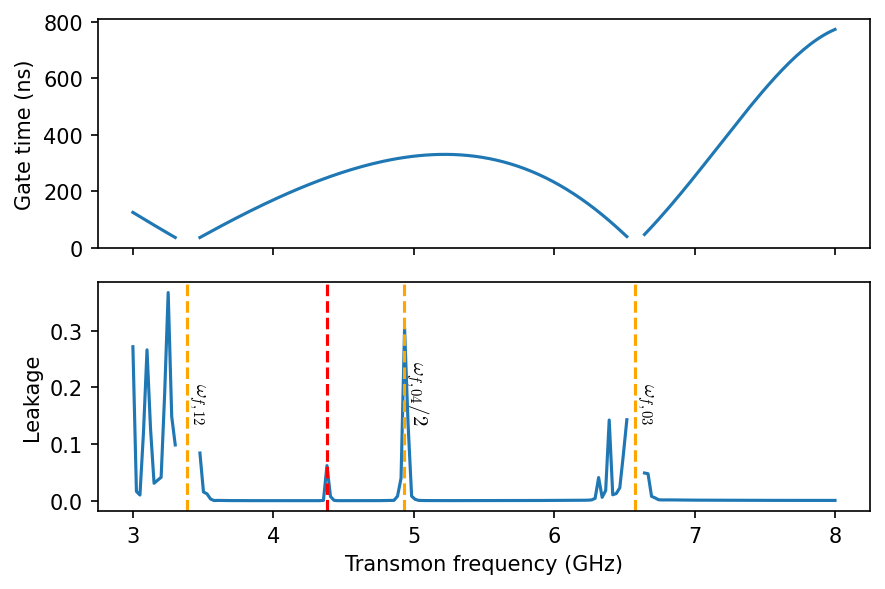

In [123]:
fig, (time_ax, leak_ax) = plt.subplots(nrows=2, sharex=True, dpi=150)
time_ax.plot(transmon_freqs, filtered_res["gate_time"])
time_ax.set_ylabel("Gate time (ns)")

leak_ax.plot(transmon_freqs, filtered_res["avg_leakage_noise"])

leak_ax.axvline(params["F_freq_1_2"], color="orange", linestyle="--")
leak_ax.text(params["F_freq_1_2"], 0.15,r'$\omega_{f, 12}$',rotation=-90)

leak_ax.axvline(params["F_freq_0_3"], color="orange", linestyle="--")
leak_ax.text(params["F_freq_0_3"], 0.15,r'$\omega_{f, 03}$',rotation=-90)

leak_ax.axvline(params["F_freq_0_4"]/2, color="orange", linestyle="--")
leak_ax.text(params["F_freq_0_4"]/2, 0.15,r'$\omega_{f, 04}/2$',rotation=-90)

leak_ax.axvline(transmon_freqs[55], color="red", linestyle="--") 

leak_ax.set_ylabel("Leakage")
leak_ax.set_xlabel("Transmon frequency (GHz)")
plt.tight_layout()
plt.show()

In [14]:
params["F_freq_1_4"]/2

4.641312119895933

In [15]:
transmon_freqs[55]

4.381909547738694